# Failed Simulations Analysis

This notebook analyzes the parameters that lead to failed ODE simulations. We'll visualize the distribution of parameter values for failed vs successful simulations to identify patterns.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import os
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Load Data

In [83]:
n_samples = 32768

sim_dir = f'outputs/simulations/output_{n_samples}_samples_fixed_T_constrained_no_overlap_venc_120'

# Load the input samples
df = pd.read_csv(os.path.join(sim_dir, f'input_samples_{n_samples}.csv'))

df.var()

ao.r           4800.146489
ao.c              0.007500
art.r        105471.968749
art.c             0.750023
ven.r             6.750206
ven.c            48.241772
av.r              3.000092
mv.r              1.400876
la.E_pas          0.001633
la.E_act          0.004800
la.v_ref          8.333588
la.k_pas          0.000033
lv.E_pas          0.083336
lv.E_act          0.750023
lv.v_ref          8.333588
lv.k_pas          0.000033
ao.l              0.000000
ao.v_ref          0.000000
art.l             0.000000
art.v_ref         0.000000
ven.l             0.000000
ven.v_ref         0.000000
la.v              0.000000
la.delay          0.000000
la.t_tr           0.000000
la.tau            0.000000
la.t_max          0.000000
lv.delay          0.000000
lv.t_tr           0.000000
lv.tau            0.000000
lv.t_max          0.000000
T                 0.000000
ao.v             21.824011
art.v          2102.831335
ven.v        707810.382195
dtype: float64

In [84]:
# Get only those columns where the variance is not zero
# non_zero_variance_cols = df.var()[df.var() > 0].index
# df = df[non_zero_variance_cols]

print(f"Total samples: {len(df)}")
print(f"Number of parameters: {len(df.columns)}")
print(f"Parameters: {list(df.columns)}")

# Load failed simulation indices
with open(os.path.join(sim_dir, 'bool_indices.json'), 'r') as f:
    failed_indices = json.load(f)

print(f"\nNumber of failed simulations: {len(failed_indices)}")
print(f"Failure rate: {len(failed_indices)/len(df)*100:.2f}%")
print(f"Failed indices: {failed_indices}")

Total samples: 32768
Number of parameters: 35
Parameters: ['ao.r', 'ao.c', 'art.r', 'art.c', 'ven.r', 'ven.c', 'av.r', 'mv.r', 'la.E_pas', 'la.E_act', 'la.v_ref', 'la.k_pas', 'lv.E_pas', 'lv.E_act', 'lv.v_ref', 'lv.k_pas', 'ao.l', 'ao.v_ref', 'art.l', 'art.v_ref', 'ven.l', 'ven.v_ref', 'la.v', 'la.delay', 'la.t_tr', 'la.tau', 'la.t_max', 'lv.delay', 'lv.t_tr', 'lv.tau', 'lv.t_max', 'T', 'ao.v', 'art.v', 'ven.v']

Number of failed simulations: 3
Failure rate: 0.01%
Failed indices: [10726, 12120, 29435]


## Create Success/Failure Labels

In [85]:
# Create a binary column for failed simulations
df['failed'] = False
df.loc[failed_indices, 'failed'] = True

# Separate successful and failed simulations
failed_df = df[df['failed'] == True].copy()
success_df = df[df['failed'] == False].copy()

print(f"Successful simulations: {len(success_df)}")
print(f"Failed simulations: {len(failed_df)}")

# Get parameter columns (exclude the 'failed' column)
param_cols = [col for col in df.columns if col != 'failed']
print(f"\nParameter columns ({len(param_cols)}): {param_cols}")

Successful simulations: 32765
Failed simulations: 3

Parameter columns (35): ['ao.r', 'ao.c', 'art.r', 'art.c', 'ven.r', 'ven.c', 'av.r', 'mv.r', 'la.E_pas', 'la.E_act', 'la.v_ref', 'la.k_pas', 'lv.E_pas', 'lv.E_act', 'lv.v_ref', 'lv.k_pas', 'ao.l', 'ao.v_ref', 'art.l', 'art.v_ref', 'ven.l', 'ven.v_ref', 'la.v', 'la.delay', 'la.t_tr', 'la.tau', 'la.t_max', 'lv.delay', 'lv.t_tr', 'lv.tau', 'lv.t_max', 'T', 'ao.v', 'art.v', 'ven.v']


## 1. Distribution Comparison for All Parameters

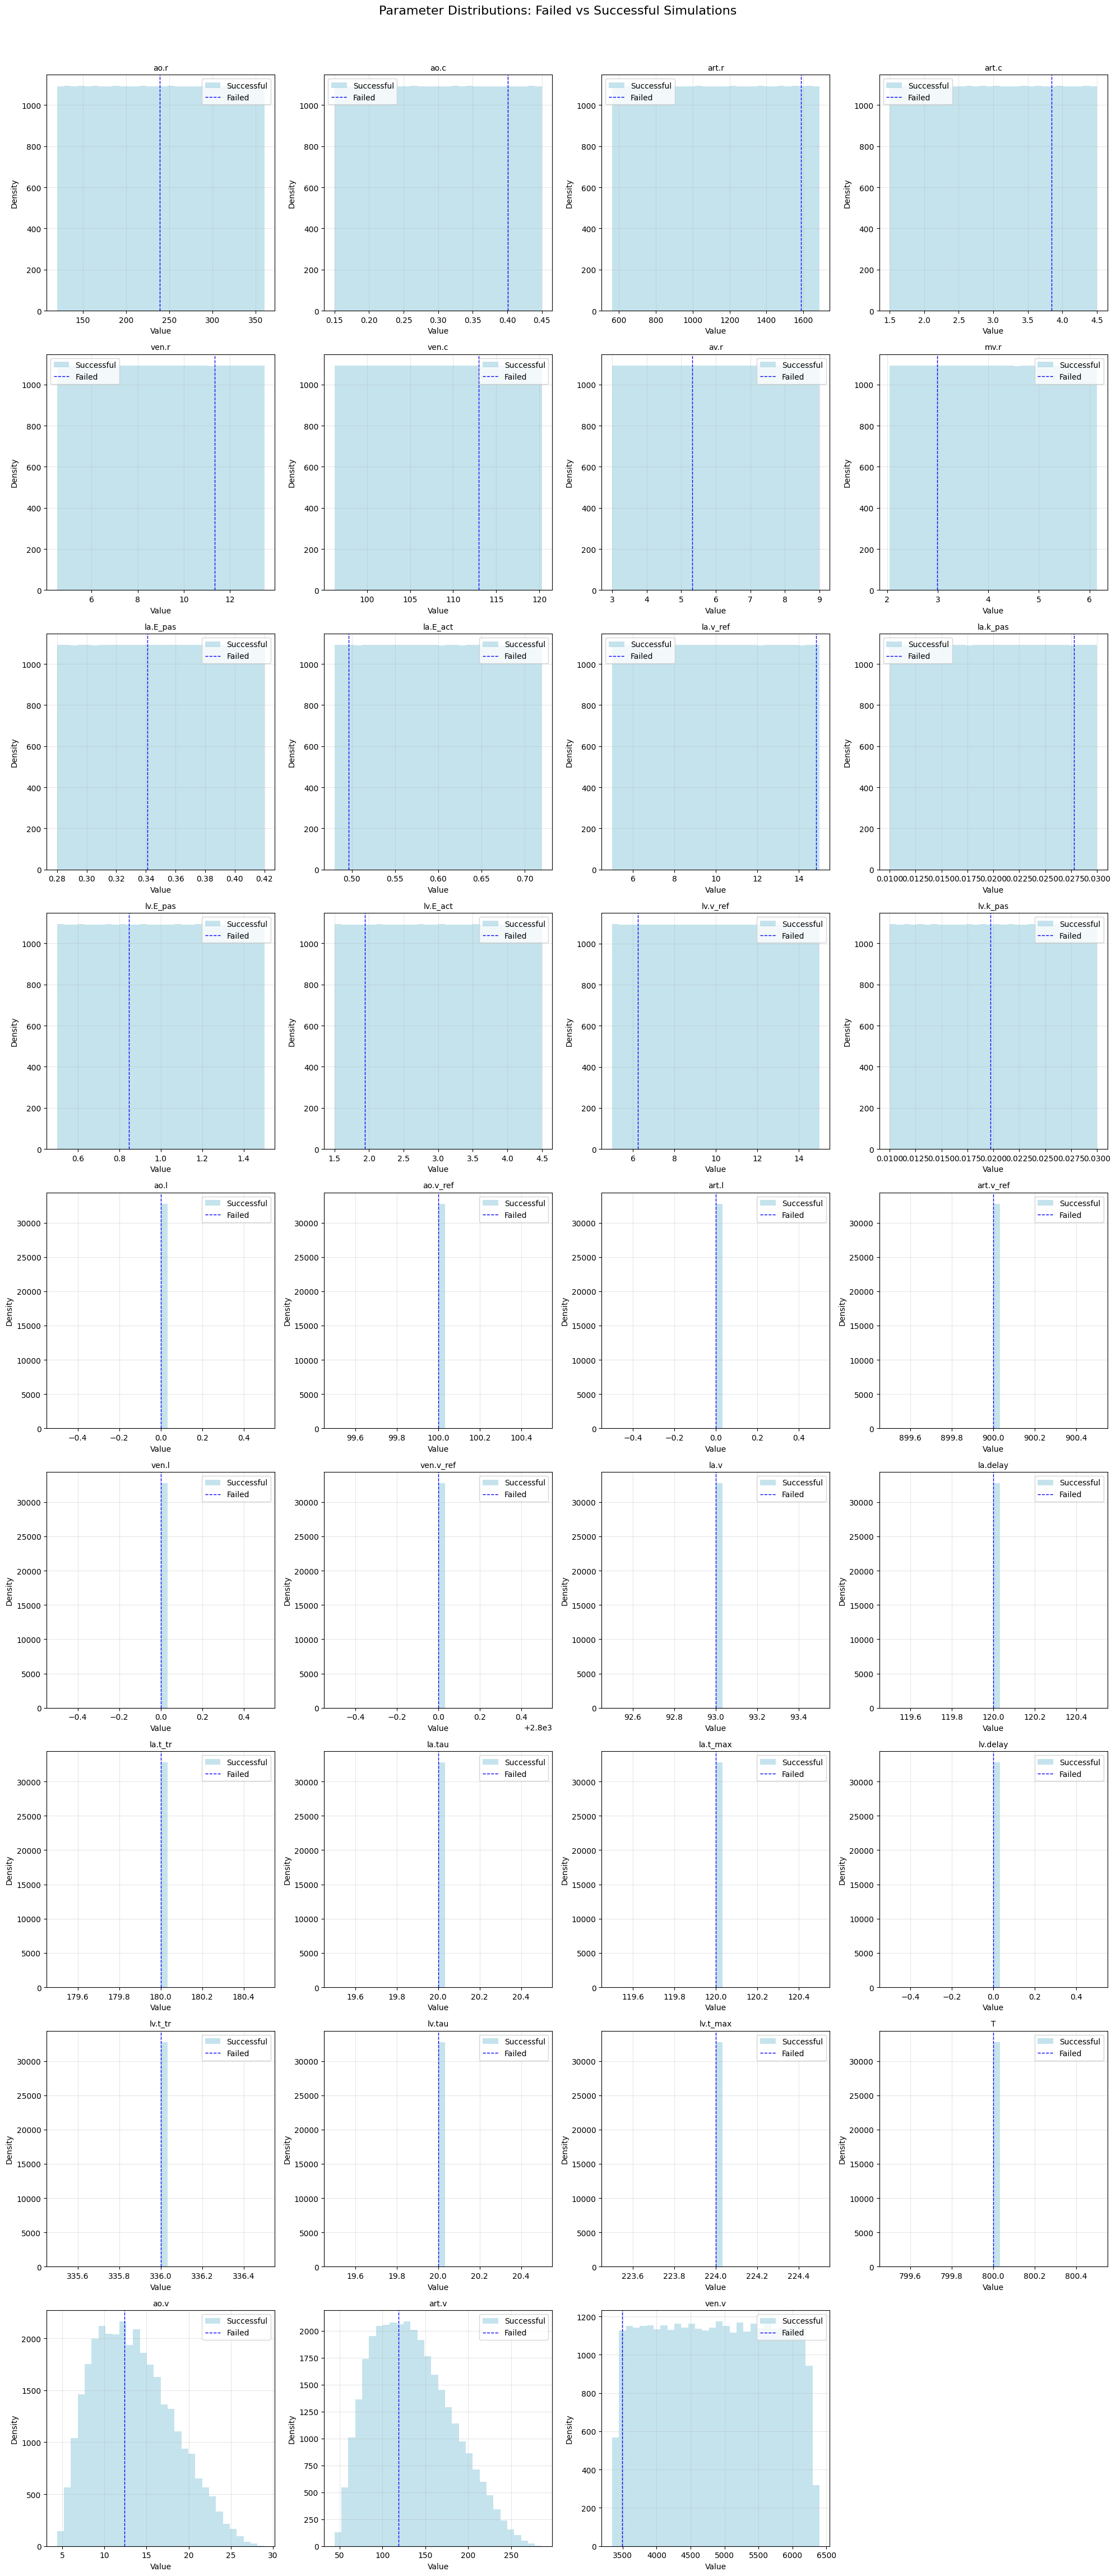

In [ ]:
# Create subplots for all parameters
n_params = len(param_cols)
n_cols = 4
n_rows = (n_params + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, param in enumerate(param_cols):
    ax = axes[i]
    
    # Plot histograms
    ax.hist(success_df[param], bins=30, alpha=0.7, label='Successful', color='lightblue', density=False)
    #ax.hist(failed_df[param], bins=30, alpha=0.7, label='Failed', color='red', density=False,)
    # we want this to be a line
    ax.axvline(failed_df[param].iloc[0], color='blue', linestyle='dashed', linewidth=1, label='Failed')
    ax.axvline(failed_df[param].iloc[1], color='green', linestyle='dashed', linewidth=1, label='Failed')
    ax.axvline(failed_df[param].iloc[2], color='red', linestyle='dashed', linewidth=1, label='Failed')        
    ax.set_title(f'{param}', fontsize=10)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_params, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Parameter Distributions: Failed vs Successful Simulations', fontsize=16, y=1.02)
plt.show()

## 2. Statistical Summary of Differences

In [87]:
# Calculate statistics for each parameter
stats_summary = []

for param in param_cols:
    success_values = success_df[param]
    failed_values = failed_df[param]
    
    # Perform t-test
    from scipy.stats import ttest_ind, mannwhitneyu
    
    try:
        t_stat, p_value = ttest_ind(success_values, failed_values)
        u_stat, p_value_mw = mannwhitneyu(success_values, failed_values, alternative='two-sided')
    except:
        t_stat, p_value = np.nan, np.nan
        u_stat, p_value_mw = np.nan, np.nan
    
    stats_summary.append({
        'Parameter': param,
        'Success_Mean': success_values.mean(),
        'Success_Std': success_values.std(),
        'Failed_Mean': failed_values.mean(),
        'Failed_Std': failed_values.std(),
        'Mean_Difference': failed_values.mean() - success_values.mean(),
        'T_Test_P_Value': p_value,
        'MW_Test_P_Value': p_value_mw
    })

stats_df = pd.DataFrame(stats_summary)
stats_df['Significant'] = stats_df['T_Test_P_Value'] < 0.05

# Sort by absolute mean difference
stats_df['Abs_Mean_Diff'] = abs(stats_df['Mean_Difference'])
stats_df = stats_df.sort_values('Abs_Mean_Diff', ascending=False)

print("Statistical Summary (sorted by absolute mean difference):")
print(stats_df[['Parameter', 'Success_Mean', 'Failed_Mean', 'Mean_Difference', 'T_Test_P_Value', 'Significant']].round(4))

Statistical Summary (sorted by absolute mean difference):
    Parameter  Success_Mean  Failed_Mean  Mean_Difference  T_Test_P_Value  \
34      ven.v     4851.9563    3497.6892       -1354.2671          0.0053   
2       art.r     1124.9573    1590.8239         465.8665          0.0130   
0        ao.r      239.9962     281.6515          41.6553          0.2977   
33      art.v      134.6747     115.6699         -19.0048          0.4729   
5       ven.c      108.2696     112.8946           4.6250          0.2488   
10   la.v_ref        9.9997      13.2098           3.2101          0.0541   
32       ao.v       13.4950      11.0921          -2.4029          0.3730   
4       ven.r        8.9998      11.3680           2.3682          0.1144   
14   lv.v_ref       10.0001       8.5128          -1.4874          0.3722   
3       art.c        2.9999       3.7090           0.7091          0.1562   
13   lv.E_act        3.0000       2.5528          -0.4473          0.3711   
6        av.r     

## 3. Box Plots for Top Discriminating Parameters

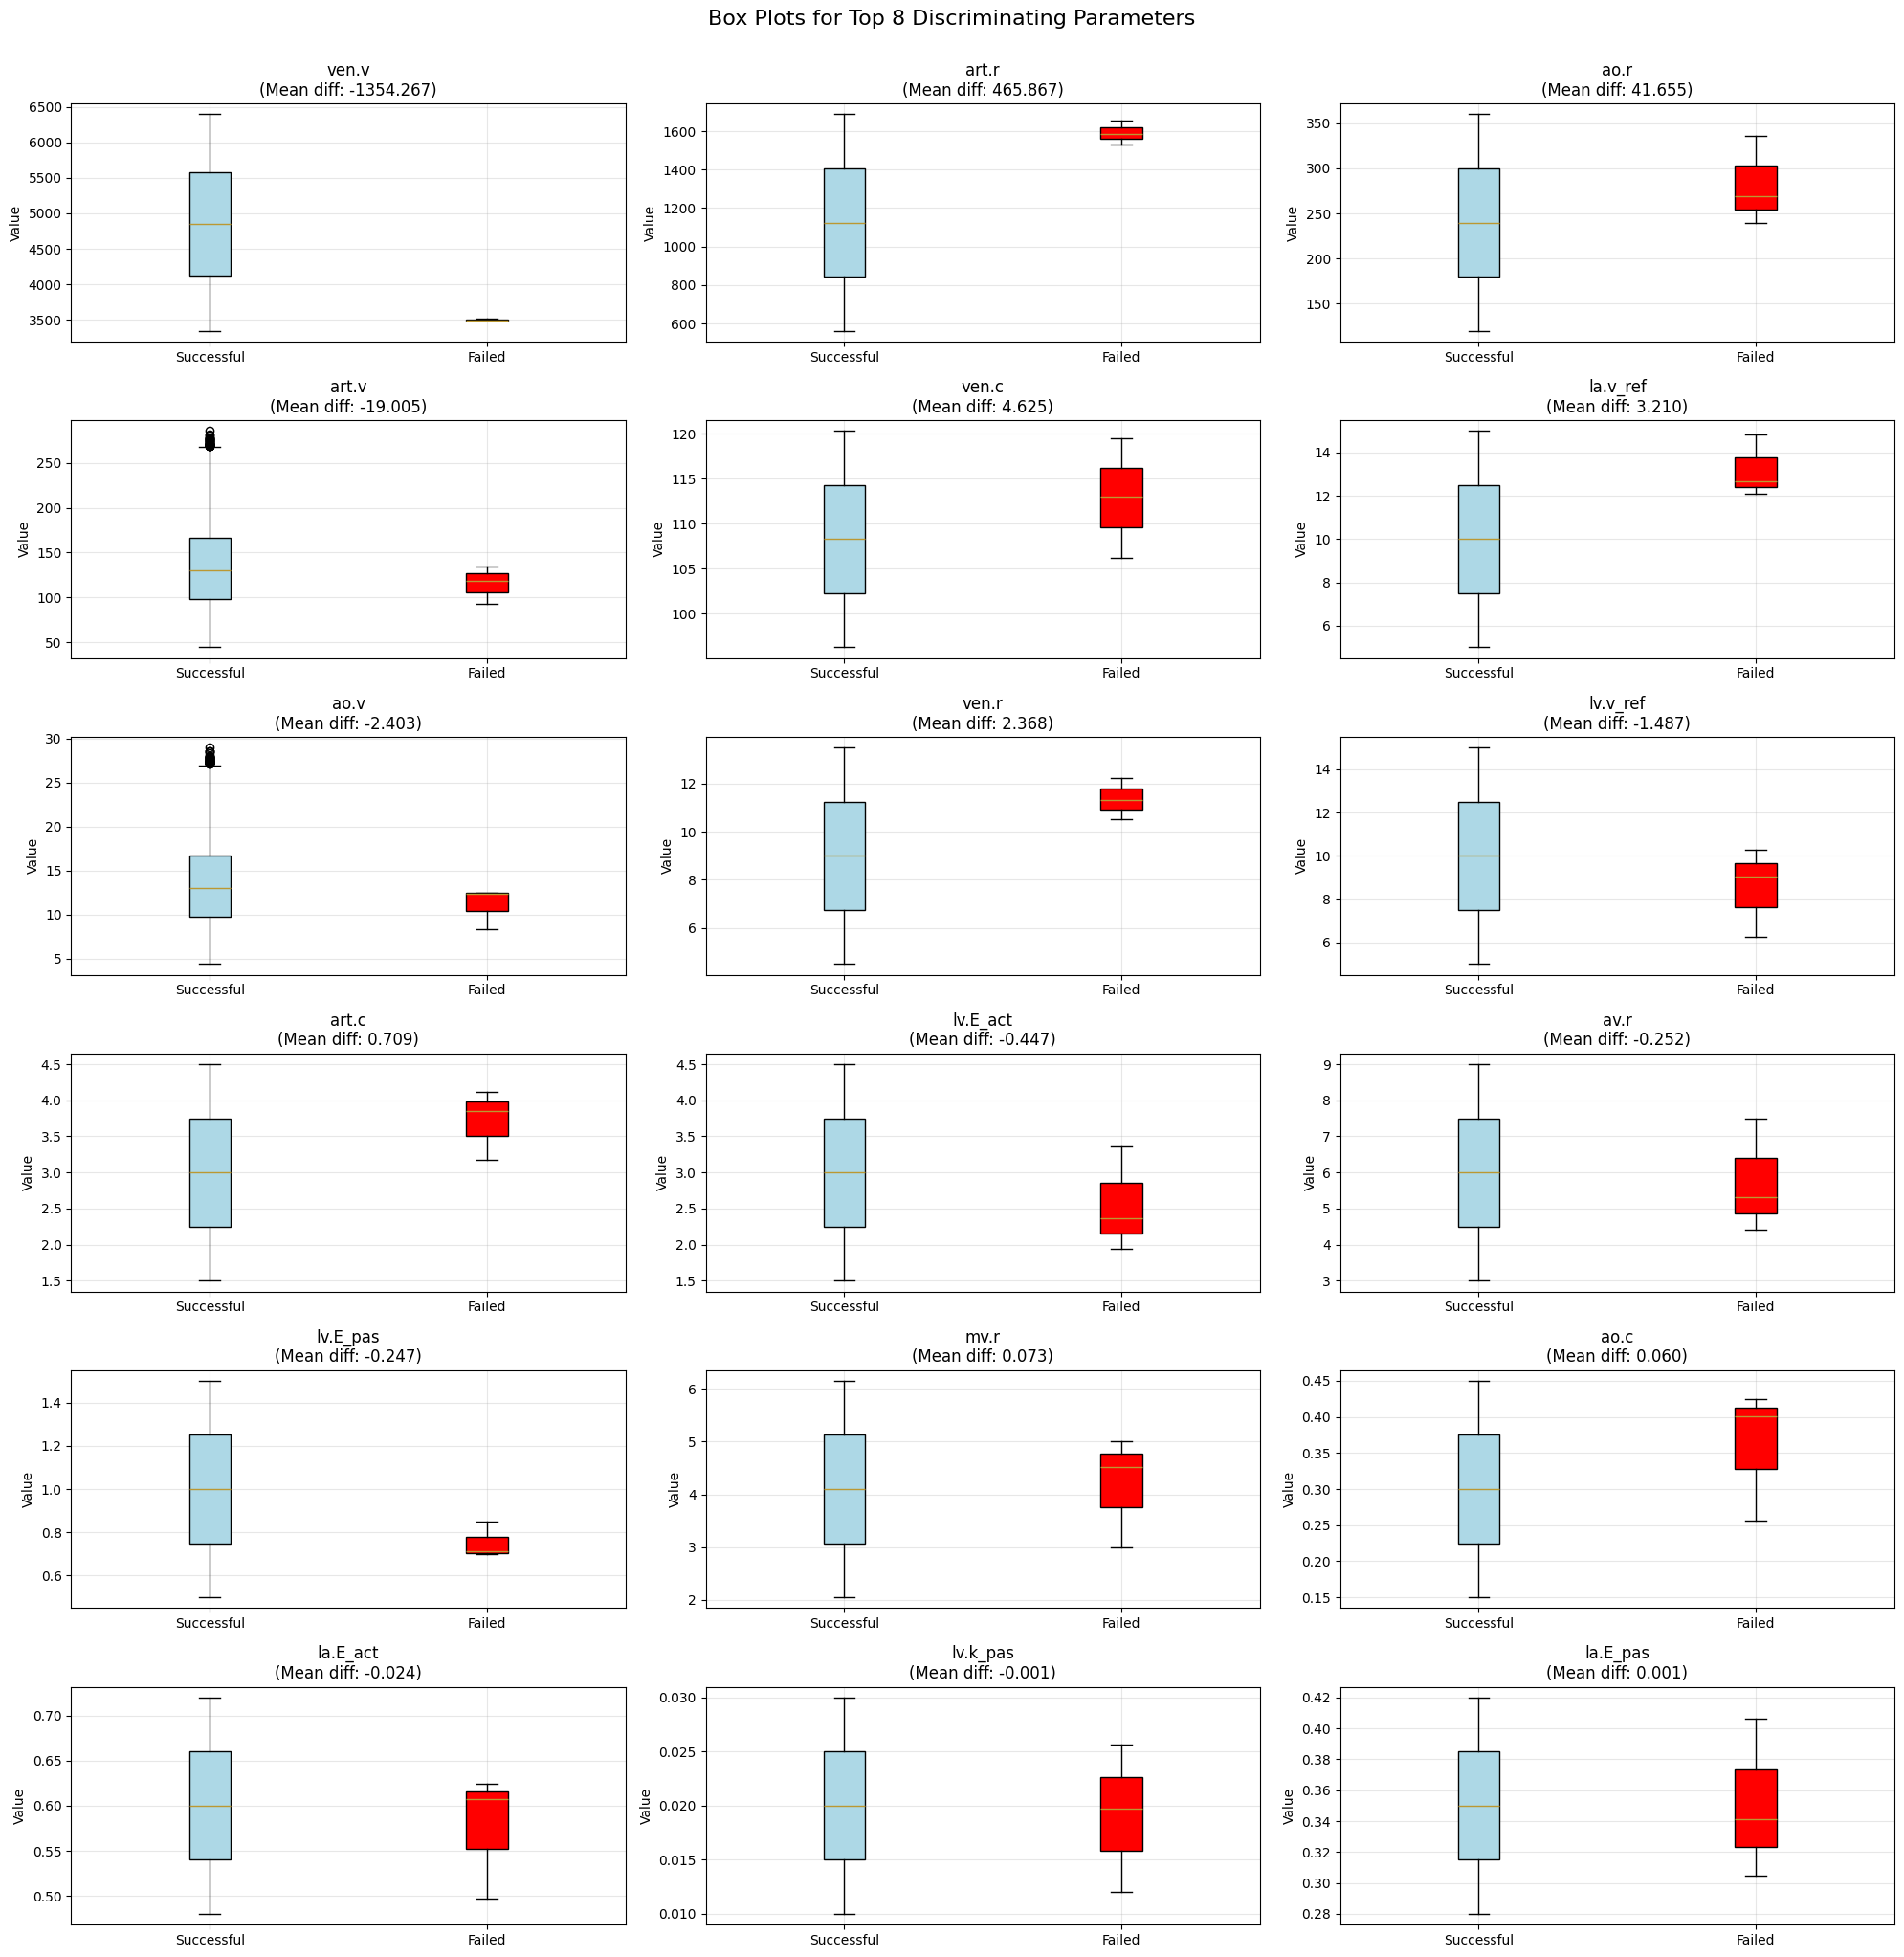

In [88]:
# Select top 8 parameters with largest differences
top_params = stats_df.head(18)['Parameter'].values

fig, axes = plt.subplots(6, 3, figsize=(20, 20))
axes = axes.flatten()

for i, param in enumerate(top_params):
    ax = axes[i]
    
    # Prepare data for box plot
    data_to_plot = [success_df[param], failed_df[param]]
    
    box_plot = ax.boxplot(data_to_plot, labels=['Successful', 'Failed'], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][1].set_facecolor('red')
    
    ax.set_title(f'{param}\n(Mean diff: {stats_df[stats_df["Parameter"]==param]["Mean_Difference"].iloc[0]:.3f})')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Box Plots for Top 8 Discriminating Parameters', fontsize=16, y=1.02)
plt.show()